In [ ]:
from qiskit.circuit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    Instruction,
)
from quantum.iceberg_codegen import build_iceberg_circuit

example_qc = QuantumCircuit(4)
example_qc.cx(0, 1)
example_qc.rzz(0.2, 1, 2)
example_qc.rxx(0.3, 2, 3)

physical, reg_bundle = build_iceberg_circuit(
    example_qc,
    optimize_level=3,
    attach_syndrome=True,
    attach_readout=True,
)

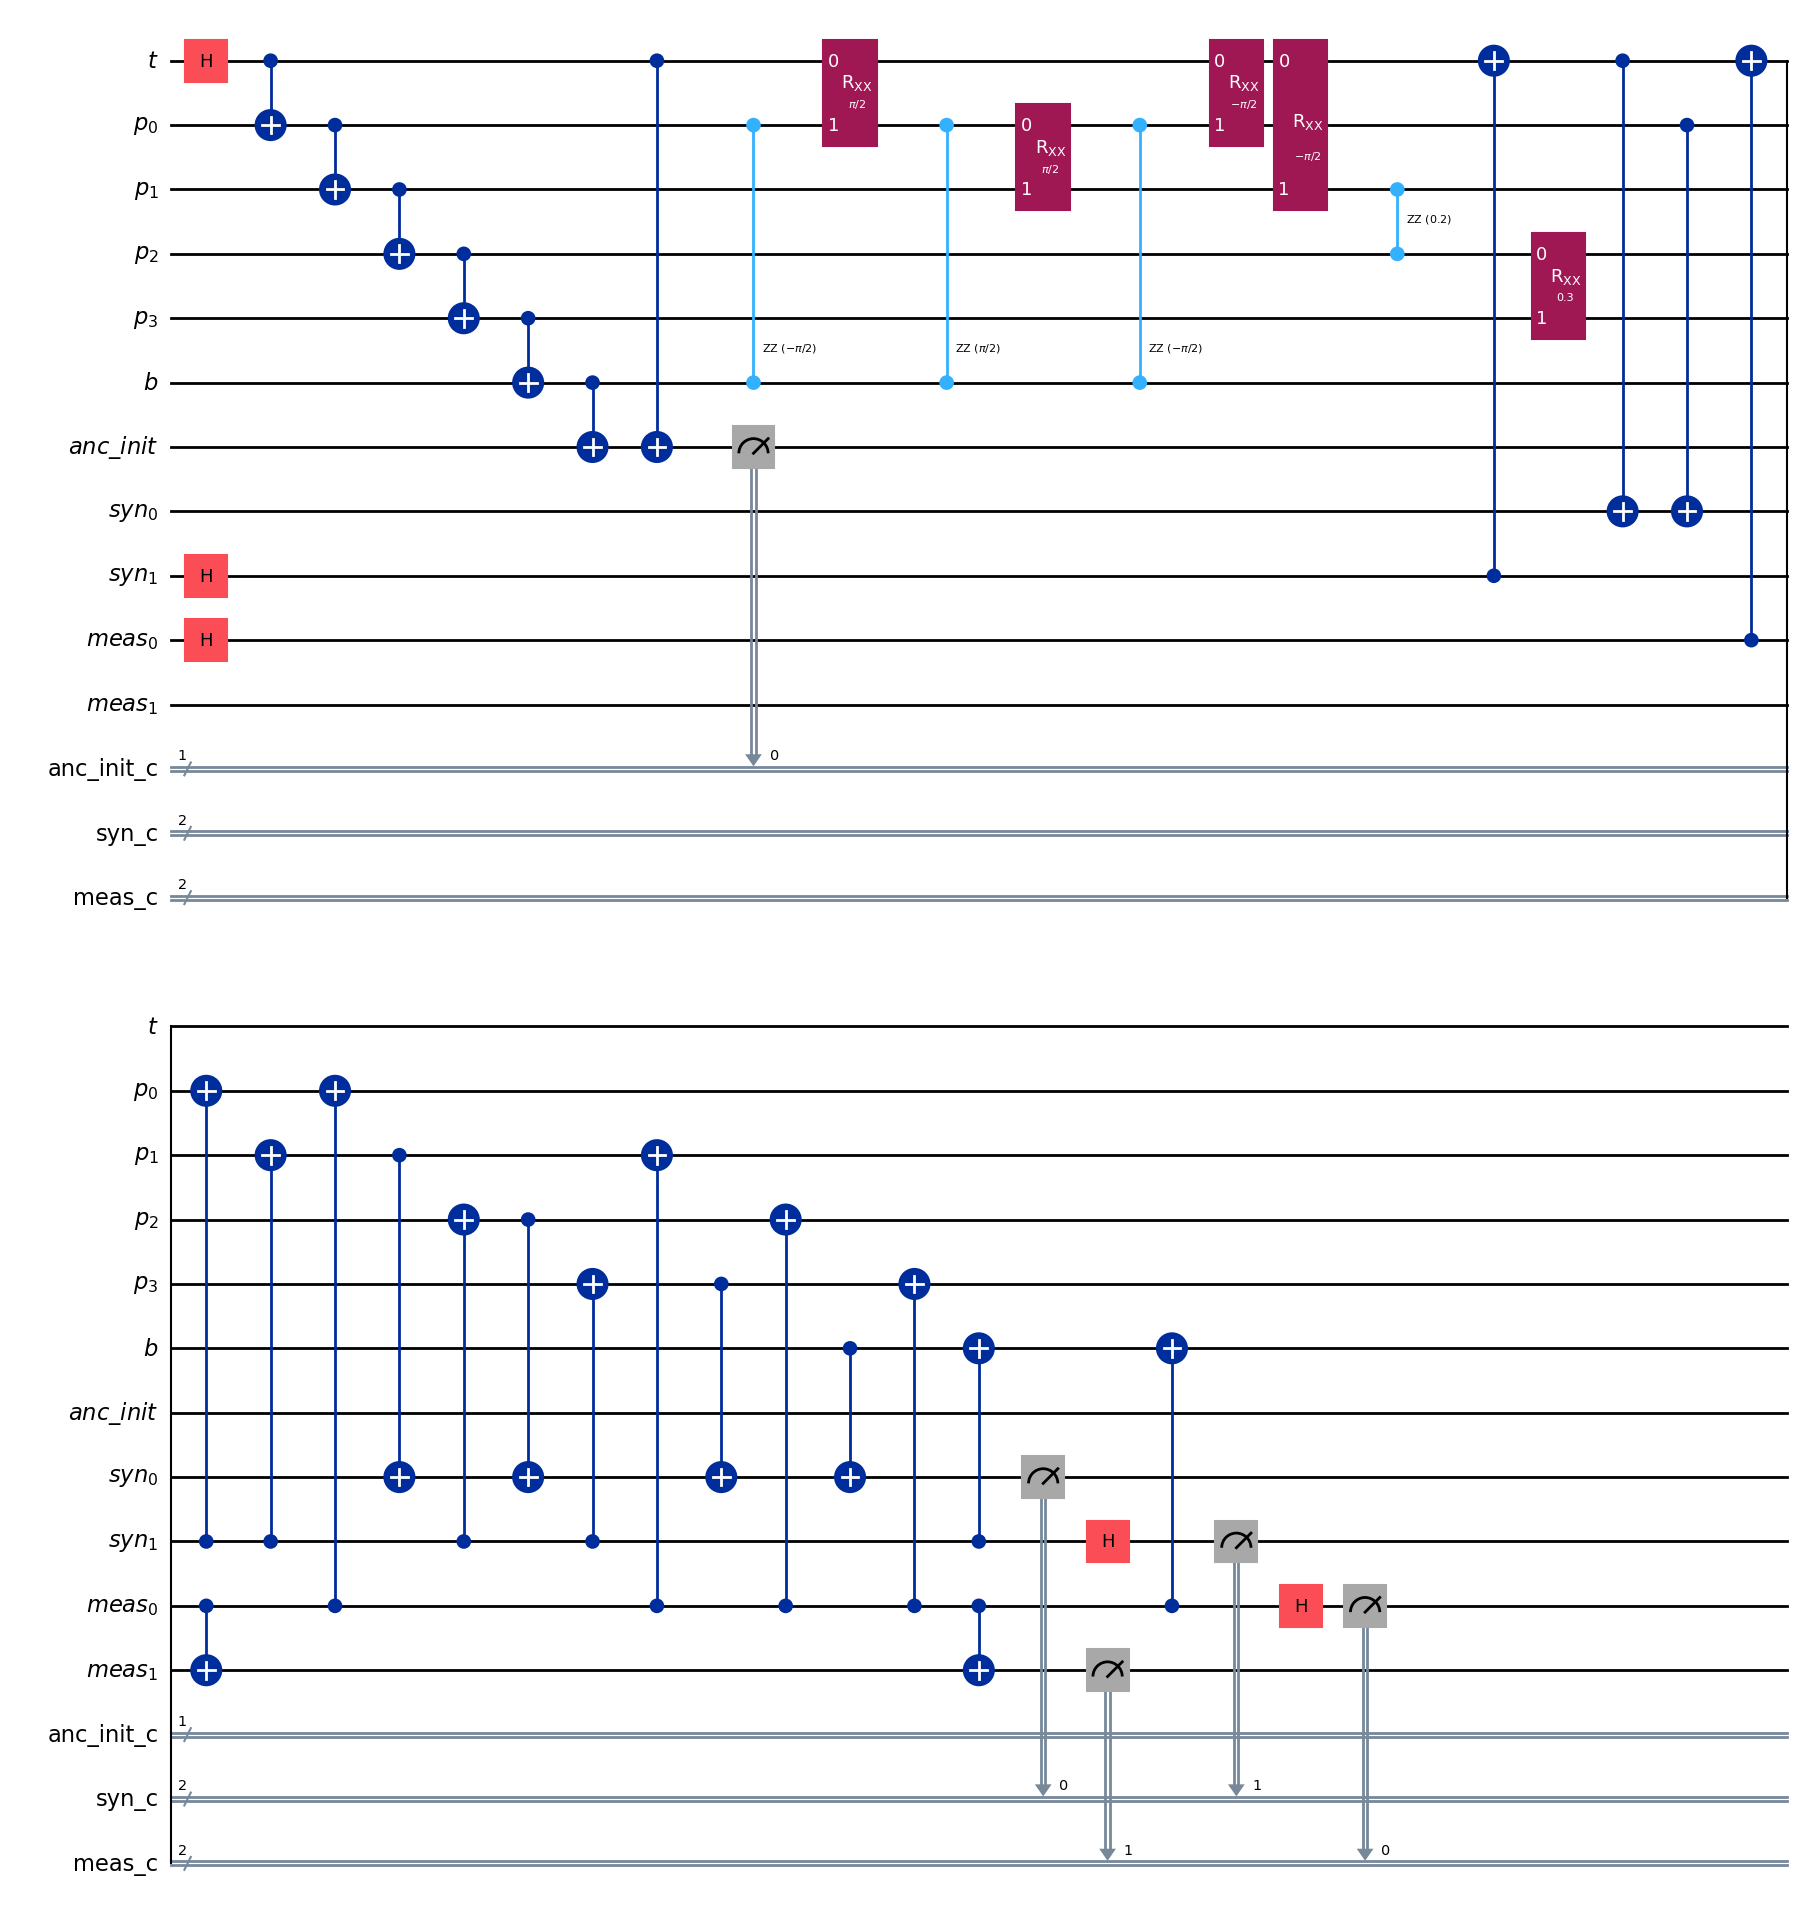

In [ ]:
physical.draw(output="mpl")